In [2]:
from torchvision import datasets, transforms
import torch
def calculate_mean_std(dataset):
    """calculate mean and standard deviation of a dataset"""
    mean = 0.0
    std = 0.0
    total_images = len(dataset)

    for img, _ in dataset:
        mean += img.mean()
        std += img.std()

    mean /= total_images
    std /= total_images

    return mean.item(), std.item()

# normalization transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load training and test datasets with normalization
trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'Before normalization: mean: {mean}, std: {std}')

# # normalization transform
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# # load training and test datasets with normalization
# trainset = datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
# valset = datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

# mean, std = calculate_mean_std(trainset)
# print(f'After normalization: mean: {mean}, std: {std}')

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


[Epoch 01] Train Loss: 0.9560 | Val Loss: 0.7048 | accuracy: 77.65%
Validation loss decreased (inf --> 0.7048). Saving model.
[Epoch 02] Train Loss: 0.4838 | Val Loss: 0.5005 | accuracy: 82.21%
Validation loss decreased (0.7048 --> 0.5005). Saving model.
[Epoch 03] Train Loss: 0.4106 | Val Loss: 0.3478 | accuracy: 88.42%
Validation loss decreased (0.5005 --> 0.3478). Saving model.
[Epoch 04] Train Loss: 0.3703 | Val Loss: 0.3761 | accuracy: 86.91%
EarlyStopping counter: 1 out of 5
[Epoch 05] Train Loss: 0.3353 | Val Loss: 0.3412 | accuracy: 88.27%
Validation loss decreased (0.3478 --> 0.3412). Saving model.
[Epoch 06] Train Loss: 0.3131 | Val Loss: 0.3257 | accuracy: 89.15%
Validation loss decreased (0.3412 --> 0.3257). Saving model.
[Epoch 07] Train Loss: 0.2897 | Val Loss: 0.3170 | accuracy: 89.19%
Validation loss decreased (0.3257 --> 0.3170). Saving model.
[Epoch 08] Train Loss: 0.2702 | Val Loss: 0.3304 | accuracy: 88.80%
EarlyStopping counter: 1 out of 5
[Epoch 09] Train Loss: 0.

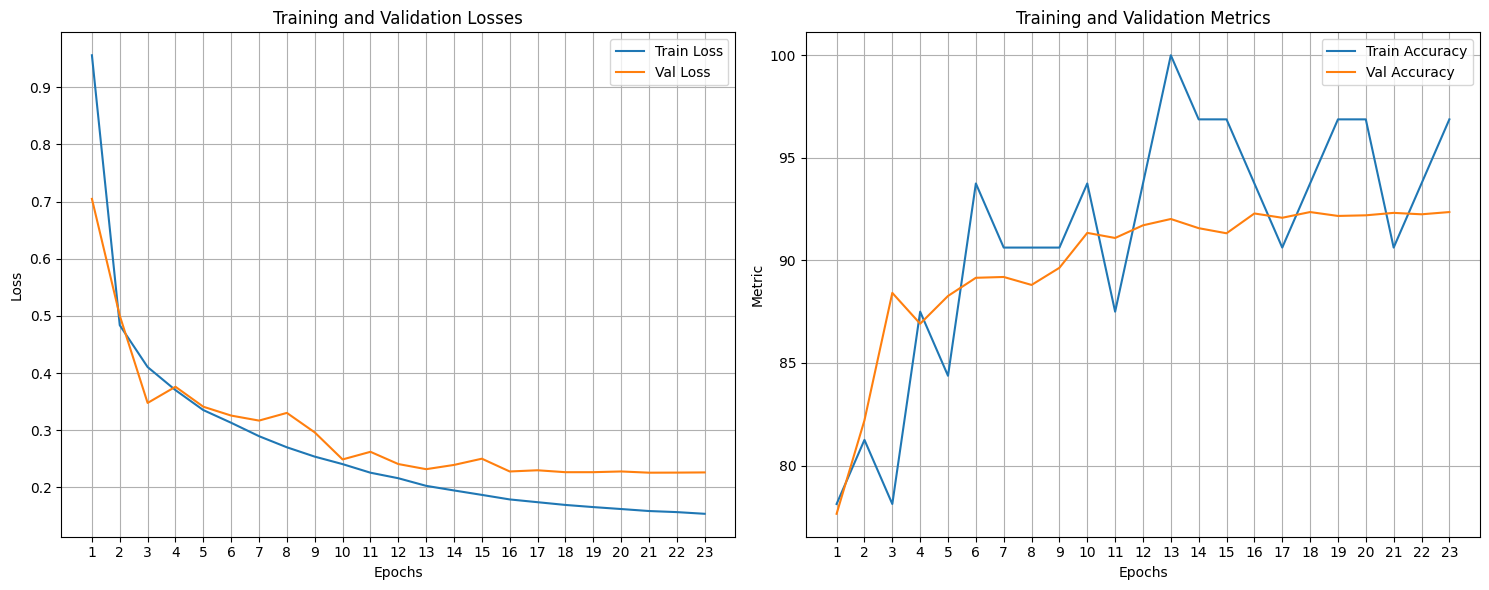

In [37]:
import torch
import torch.nn as nn
from torch.optim import Adadelta
from torch.optim.lr_scheduler import StepLR
import sys
from pathlib import Path


# sys.path.append(str(utils_dir))
utils_dir = Path('/home/goose/projects/deeplearning/utils')
sys.path.append(str(utils_dir))
from metrics import precision, recall, f1_score
from trainer import ModelTrainer


# model
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)  # batch norm after first conv
        self.bn2 = nn.BatchNorm2d(64)  # batch norm after second conv
        self.bn3 = nn.BatchNorm2d(128)  # batch norm after third conv
        # size calculation
        # 28x28 → conv1: 28x28
        # 28x28 → conv2: 28x28 → pool: 14x14
        # 14x14 → conv3: 14x14 → pool: 7x7
        # 7x7 → flatten: 7 * 7 * 128 = 6272
        flattened_size = 6272

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(flattened_size, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # regularization
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # conv1 + batch norm + pooling
        x = self.relu(self.conv1(x))
        # conv2 + batch norm + pooling
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        # conv3 + batch norm + pooling
        x = self.pool(self.bn3(self.relu(self.conv3(x))))

        # flatten and fully connected layer
        x = self.flatten(x)
        x = self.fc(self.relu(x))
        x = self.dropout2(x)
        x = self.fc2(self.relu(x))
        x = self.dropout(x)
        x = self.fc3(self.relu(x))
        x = self.dropout(x)
        x = self.fc4(self.relu(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# initialize model
model = Net(input_size=28*28, output_size=10)
# initialize optimizer
optimizer = Adadelta(model.parameters(), lr=1, weight_decay=0.01)
# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=64,
    verbose=True,
    early_stopping_patience=5,
    early_stopping_delta=0.001,
    metrics=[ModelTrainer.accuracy]
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=100
)

[Epoch 01] Train Loss: 0.5536 | Val Loss: 0.4885 | accuracy: 82.74%
Validation loss decreased (inf --> 0.4885). Saving model.
[Epoch 02] Train Loss: 0.3883 | Val Loss: 0.3603 | accuracy: 87.10%
Validation loss decreased (0.4885 --> 0.3603). Saving model.
[Epoch 03] Train Loss: 0.3480 | Val Loss: 0.3309 | accuracy: 88.64%
Validation loss decreased (0.3603 --> 0.3309). Saving model.
[Epoch 04] Train Loss: 0.3232 | Val Loss: 0.2844 | accuracy: 89.93%
Validation loss decreased (0.3309 --> 0.2844). Saving model.
[Epoch 05] Train Loss: 0.2998 | Val Loss: 0.2813 | accuracy: 90.03%
Validation loss decreased (0.2844 --> 0.2813). Saving model.
[Epoch 06] Train Loss: 0.2811 | Val Loss: 0.2682 | accuracy: 90.62%
Validation loss decreased (0.2813 --> 0.2682). Saving model.
[Epoch 07] Train Loss: 0.2685 | Val Loss: 0.2374 | accuracy: 91.60%
Validation loss decreased (0.2682 --> 0.2374). Saving model.
[Epoch 08] Train Loss: 0.2505 | Val Loss: 0.2396 | accuracy: 91.74%
EarlyStopping counter: 1 out of 5
[Epoch 09] Train Loss: 0.2390 | Val Loss: 0.2382 | accuracy: 91.59%
EarlyStopping counter: 2 out of 5
[Epoch 10] Train Loss: 0.2270 | Val Loss: 0.2237 | accuracy: 92.24%
Validation loss decreased (0.2374 --> 0.2237). Saving model.
[Epoch 11] Train Loss: 0.2170 | Val Loss: 0.2178 | accuracy: 92.35%
Validation loss decreased (0.2237 --> 0.2178). Saving model.
[Epoch 12] Train Loss: 0.2095 | Val Loss: 0.2234 | accuracy: 92.25%
EarlyStopping counter: 1 out of 5
[Epoch 13] Train Loss: 0.2037 | Val Loss: 0.2138 | accuracy: 92.51%
Validation loss decreased (0.2178 --> 0.2138). Saving model.
[Epoch 14] Train Loss: 0.1934 | Val Loss: 0.2156 | accuracy: 92.52%
EarlyStopping counter: 1 out of 5
[Epoch 15] Train Loss: 0.1919 | Val Loss: 0.2135 | accuracy: 92.59%
EarlyStopping counter: 2 out of 5
[Epoch 16] Train Loss: 0.1866 | Val Loss: 0.2104 | accuracy: 92.84%
Validation loss decreased (0.2138 --> 0.2104). Saving model.
[Epoch 17] Train Loss: 0.1846 | Val Loss: 0.2105 | accuracy: 92.84%
EarlyStopping counter: 1 out of 5
[Epoch 18] Train Loss: 0.1803 | Val Loss: 0.2096 | accuracy: 92.83%
EarlyStopping counter: 2 out of 5
[Epoch 19] Train Loss: 0.1761 | Val Loss: 0.2101 | accuracy: 92.67%
EarlyStopping counter: 3 out of 5
[Epoch 20] Train Loss: 0.1737 | Val Loss: 0.2104 | accuracy: 92.74%
EarlyStopping counter: 4 out of 5

In [4]:
import sys
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/goose/projects/deeplearning/venv/lib/python3.10/site-packages',
 '/home/gustaf/projects/deeplearning/utils',
 '/tmp/tmpx4vri6g1',
 '/home/gustaf/projects/deeplearning/utils']

In [11]:
print(type(1e-3))

<class 'float'>


In [12]:
print(type(0.001))

<class 'float'>
